In [52]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


### Progress
6/14/24
5.5 hours
Parameter tuned
Got rid of the - np.eye(self.d) in the gaussian step
added the dimensionality fix by adding trace to the loss (subtract the identity)
Added spiral shape
Made animation
Showed that when validation set decreases, it actually still looks okay
Experimented with differnt deliberate covariance shapes, on the spiral it works well at different positions (fixes gaps if its the right spot, but if wrong spot makes it worse. This shows that the variable covariance matrix would work well on the spiral)

Next: 
do BFGS and stochastic gradient descent. (stochastic BFGS?)
Other speed up improvements


In [53]:
class model3():
    def __init__(self, max_iter=1000, tol=1e-8, learning_rate=0.01, reg = 10, dim_reg = 0, stochastic=False, batch_size=32, epochs = 100):
        # Hyperparameters
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.stochastic = stochastic
        self.batch_size = batch_size
        self.epochs = epochs
        self.reg = reg
        self.dim_reg = dim_reg

        # Variables to store
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        self.weights = None
        self.classes = None
        self.num_classes = None
        self.y_dict = None
        self.one_hot = None
        self.differences = None
        self.X_val_set = None
        self.y_val_set = None
        self.class_index = []
        self.val_history = []
        self.train_history = []
        self.weights_history = []
        

    ############################## Helper Functions ###############################
    def label_from_stationary(self, stationary, show_probabilities = False):
        """Get the label from the stationary distribution
        Input:
            stationary (n,) ndarray - The stationary distribution of the data
        Output:
            labels (n,) ndarray - The predicted labels of the data"""
        
        # Check if the sum of the stationary distribution is approximately 1
        if not np.isclose(np.sum(stationary), 1):
            raise ValueError("The weights do not sum to 1.")
        
        # Sum the weights for each class
        class_probabilities = np.zeros(self.num_classes)
        for weight, label in zip(stationary, self.y):
            class_probabilities[self.y_dict[label]] += weight

        # Return the probabilities if requested
        if show_probabilities:
            return class_probabilities
        
        # Otherwise, return the class with the highest weight
        else:
            indices = np.argmax(class_probabilities)
            return self.classes[indices]
        
    def get_gaussian(self, weights):
        """ Get the gaussian kernel for the informative points
        Input:
            informative_points (n,d) ndarray - The informative points
            target (n,) ndarray - The target values
            weights (d,) ndarray - The weights for the informative points
        Output:
            gaussian (n,n) ndarray - The gaussian kernel for the informative points"""
        tensor_prod = np.einsum('ijk,lk->ijl', self.differences, weights)
        return np.exp(-np.linalg.norm(tensor_prod, axis=2)).T, tensor_prod
    

    def encode_y(self,y):
        # Check if the input is a list
        if isinstance(y, list):
            y = np.array(y)

        # Make sure it is a numpy array
        elif not isinstance(y, np.ndarray):
            raise ValueError("y must be a list or a numpy array")
        
        # If it is not integers, give it a dictionary
        if y.dtype != int:
            self.classes = np.unique(y)
            self.num_classes = len(self.classes)
            self.y_dict = {label: i for i, label in enumerate(np.unique(y))}

        # If it is, still make it a dictionary
        else:
            self.classes = np.arange(np.max(y)+1)
            self.num_classes = len(self.classes)
            self.y_dict = {i: i for i in self.classes}

        # Create an index array
        for i in range(self.num_classes):
            self.class_index.append(np.where(y == self.classes[i])[0])

        # Make a one hot encoding
        self.one_hot = np.zeros((self.n, self.num_classes))
        for i in range(self.n):
            self.one_hot[i, self.y_dict[y[i]]] = 1


    ############################## Training Functions ##############################
    def gradient(self, W):
        # Get the gaussian kernel, and tensor product
        gaussian, tensor_prod = self.get_gaussian(W) 
        dW = np.zeros((self.d,self.d))

        # Loop through the different classes and select the right subsets
        for i in range(len(self.classes)):
            g_c = gaussian[self.class_index[i]]
            g_c_totals = np.sum(g_c, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
            product_c = tensor_prod[self.class_index[i]]
            differences_c = self.differences[self.class_index[i]]

            # Calculate the weighted products
            weighted_product_c = g_c[:,:,np.newaxis] * product_c
            weighted_sum_c = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_c, differences_c), axis = 0)
            weighted_sum_c /= g_c_totals

            # Calculate the gradient first term
            dW += np.sum(self.one_hot[:,i][:,np.newaxis, np.newaxis] * weighted_sum_c, axis=0)

        # Calculate the gradient first term
        g_all_totals = np.sum(gaussian, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
        weighted_product_all = gaussian[:,:,np.newaxis] * tensor_prod
        weighted_sum_all = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_all, self.differences), axis = 0)
        weighted_sum_all /= g_all_totals

        # Calculate the gradient second term
        dW -= np.sum(weighted_sum_all, axis=0)

        # Return the regularized gradient
        return 2*dW + self.reg*(W / np.linalg.norm(W, 'fro') - self.dim_reg*np.eye(self.d) /self.d)

    def gradient_descent(self):
        show_iter = max(self.max_iter,100) // 100
        for i in range(self.max_iter):
            # Get the gradient
            gradient = self.gradient(self.weights)
            self.weights -= self.learning_rate * gradient
            self.weights_history.append(self.weights.copy())

            # If there is a validation set, check the validation error
            if self.X_val_set is not None and self.y_val_set is not None:
                
                # Predict on the validation set and append the history
                val_predictions = self.predict(self.X_val_set)
                val_accuracy = accuracy_score(self.y_val_set, val_predictions)
                self.val_history.append(val_accuracy)

                # Predict on the training set and append the history
                train_predictions = self.predict(self.X)
                train_accuracy = accuracy_score(self.y, train_predictions)
                self.train_history.append(train_accuracy)
                
                # Show the progress
                if i % show_iter == 0:
                    print(f"({i}) Val Accuracy: {np.round(val_accuracy,5)}.   Train Accuracy: {train_accuracy}")
                    # plt.imshow(self.weights)
                    # plt.show()

            # Check for convergence after a certain number of iterations
            break_value = np.linalg.norm(gradient)
            if break_value < self.tol*self.n and i > self.max_iter//50:
                break

    def stochastic_gradient_descent(self):
        pass

    def fit(self, X, y, X_val_set = None, y_val_set = None):
        # Save the data as variables
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.weights = .125*((np.random.random((self.d,self.d))*2 - 1) + np.eye(self.d))
        self.encode_y(y)

        # If there is a validation set, save it
        if X_val_set is not None and y_val_set is not None:
            self.X_val_set = X_val_set
            self.y_val_set = y_val_set

        # Perform necessary calculations
        self.differences = self.X[:,np.newaxis,:] - self.X[np.newaxis,:,:]

        # If it is not stochastic, run the gradient descent
        if not self.stochastic:
            self.gradient_descent()

        # Otherwise, run the stochastic gradient descent
        else:
            self.stochastic_gradient_descent()

    

    ############################## Prediction Functions #############################
    def predict(self, points, show_probabilities=False):
        """Predict the labels of the data
        Input:
            points (n,d) ndarray - The data to predict
        Output:
            predictions (n,) ndarray - The predicted labels of the data"""
        # Check the shape of the data and the point and initialize the predictions
        if len(points.shape) == 1:
            points = points[np.newaxis,:]
        predictions = []

        # Get the differences array
        differences = self.X[:,np.newaxis,:] - points[np.newaxis,:,:]
        probs = np.exp(-np.linalg.norm(np.einsum('ijk,lk->ijl', differences, self.weights), axis=2)).T + 1e-75
        probs /= np.sum(probs, axis=1, keepdims=True)
        
        # Loop through the different points and get the predictions
        for i in range(points.shape[0]):
            predictions.append(self.label_from_stationary(probs[i], show_probabilities=show_probabilities))

        # Return the predictions
        return np.array(predictions)


    ############################## Analysis Functions ###############################
    def copy(self):
        return self
        

### 2D plotting functions

In [54]:
def show_probs(model, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points, show_probabilities=True)[:,1]
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm, levels = 100)
    level_set = plt.contour(xx, yy, Z, levels=[0.5], colors='grey', linestyles='dashed', linewidths=.5)
    plt.clabel(level_set)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    # Plot the 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, 1-Z, cmap='coolwarm')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability of being in class 1')
    plt.show()

def plot_boundary(model, title, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points)
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    predictions_y = np.linalg.norm(grid_points, axis=1)>1
    print("Coverage: ", accuracy_score(predictions, predictions_y))

def animate_boundary(model, title, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Make the figure
    fig = plt.figure(figsize=(6, 6))

    def update(iter):
        print(iter)
        model_used = model.copy()
        model_used.weights = model.weights_history[iter]
        predictions = model_used.predict(grid_points)
        Z = np.array(predictions).reshape(xx.shape)
        plt.clf()
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f" Iteration: {iter} Validation Accuracy: {model.val_history[iter]}")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        circle = plt.Circle((0, 0), 1, color='k', fill=False)
        plt.gca().add_artist(circle)
        
    ani = FuncAnimation(fig, update, frames=range(len(model.weights_history)), repeat=False)
    ani.save(title+".mp4")

def animate_weights(model, title):
    model_used = model.copy()
    # Make the figure
    fig = plt.figure(figsize=(6, 6))

    def update(iter):
        weights = model_used.weights_history[iter]
        plt.clf()
        plt.imshow(weights)
        plt.title(f" Iteration: {iter} Validation Accuracy: {model.val_history[iter]}")
        plt.colorbar()
    ani = FuncAnimation(fig, update, frames=range(len(model.weights_history)), repeat=False)
    ani.save(title+".mp4")



Sometimes it goes to a singular matrix, Still pretty good though
adding regularization helps
sometimes the accuracy improves, then with further training deteriorates, why?
subtracting out the identity difference

1. Bayesian approach try it
2. Hold off on deep learning
3. Start SGD, then move to BFGS and then double check of there is stochastic BFGS
4. Look for dimensionality preservation regularization

Dataset recommendations
mnist, fashion mnist, sipher 10
tabular data



(0) Val Accuracy: 0.796.   Train Accuracy: 0.756
(1) Val Accuracy: 0.796.   Train Accuracy: 0.756
(2) Val Accuracy: 0.796.   Train Accuracy: 0.756
(3) Val Accuracy: 0.796.   Train Accuracy: 0.756
(4) Val Accuracy: 0.796.   Train Accuracy: 0.756
(5) Val Accuracy: 0.796.   Train Accuracy: 0.756
(6) Val Accuracy: 0.806.   Train Accuracy: 0.788
(7) Val Accuracy: 0.854.   Train Accuracy: 0.844
(8) Val Accuracy: 0.856.   Train Accuracy: 0.898
(9) Val Accuracy: 0.856.   Train Accuracy: 0.898
(10) Val Accuracy: 0.856.   Train Accuracy: 0.9
(11) Val Accuracy: 0.858.   Train Accuracy: 0.9
(12) Val Accuracy: 0.856.   Train Accuracy: 0.9
(13) Val Accuracy: 0.856.   Train Accuracy: 0.9
(14) Val Accuracy: 0.856.   Train Accuracy: 0.904
(15) Val Accuracy: 0.856.   Train Accuracy: 0.904
(16) Val Accuracy: 0.856.   Train Accuracy: 0.906
(17) Val Accuracy: 0.856.   Train Accuracy: 0.906
(18) Val Accuracy: 0.856.   Train Accuracy: 0.908
(19) Val Accuracy: 0.856.   Train Accuracy: 0.912
(20) Val Accuracy:

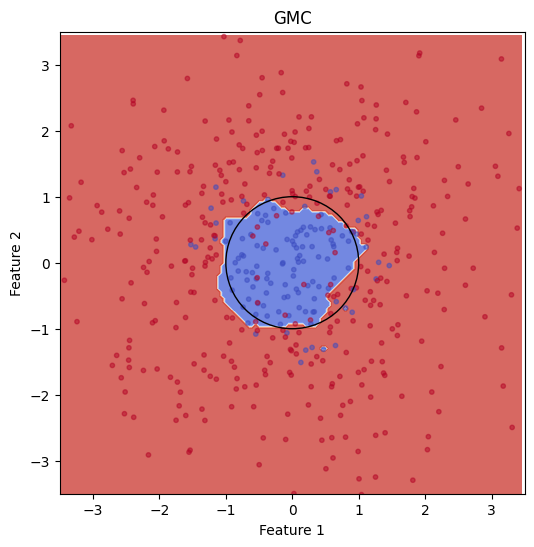

Coverage:  0.9862755102040817


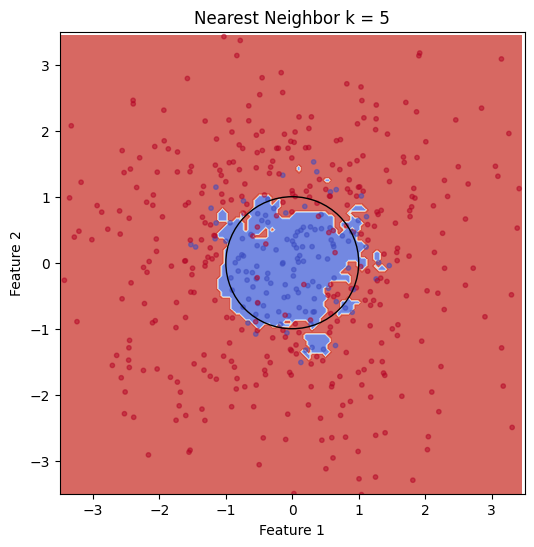

Coverage:  0.9778061224489796


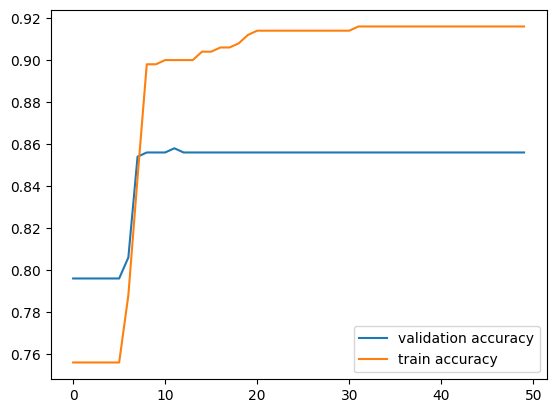

In [92]:
#np.random.seed(47)
X = np.random.multivariate_normal([0,0], np.array([[2,0],[0,2]]), 1000)
y = np.linalg.norm(X, axis=1)>1
# t = np.arange(0, 2*2*np.pi, 0.1)
# spiral = t[:,np.newaxis]*np.array([np.cos(t), np.sin(t)]).T/5
# distance = np.min(np.linalg.norm(X[:,np.newaxis,:] - spiral[np.newaxis,:,:], axis=2), axis=1)
# y = distance<.25
X += np.random.normal(0, .4, X.shape)

x_val = X[500:]
y_val = y[500:]
X = X[:500]
y = y[:500]


# plt.scatter(X[:,0], X[:,1], c=y)
# plt.plot(spiral[:,0], spiral[:,1])
# plt.show()

test = np.random.multivariate_normal([0,0], np.array([[2,0],[0,2]]), 100)
test_y = np.linalg.norm(test, axis=1)>1

model_toy = model3(learning_rate=.025, reg = 50, dim_reg = 0.1, max_iter=50)
model_toy.fit(X, y, X_val_set= x_val, y_val_set=y_val)
# print("begin prediction")
# predictions = model.predict(test)
print(model_toy.weights)
# print(accuracy_score(predictions, test_y))

# nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
neighbors = 5
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X, y)

best_prediction = np.linalg.norm(x_val, axis=1)>1
print(accuracy_score(best_prediction, y_val))

plot_boundary(model_toy, "GMC", h=.05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])
plot_boundary(knn, f"Nearest Neighbor k = {neighbors}",h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])
plt.plot(model_toy.val_history, label = "validation accuracy")
plt.plot(model_toy.train_history, label = "train accuracy")
plt.legend()
plt.show()

In [56]:
# animation.writer = animation.writers['ffmpeg']
# animate_boundary(model_toy, "GMC Spiral", h=.075, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])

In [57]:
cov_inv = model_toy.weights.T @ model_toy.weights
cov = np.linalg.inv(cov_inv)
print(cov_inv)
print(cov)
print(cov_inv[0] /cov_inv[1])

[[82.85779969 -0.92582262]
 [-0.92582262 80.10874243]]
[[0.01207043 0.0001395 ]
 [0.0001395  0.01248464]]
[-8.94964093e+01 -1.15570734e-02]


In [81]:
# load digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# randomly choose a subset of the data
# np.random.seed(29)
indices = np.random.choice(X_train_val.shape[0], 200, replace=False)
val_indices = np.setdiff1d(np.arange(X_train_val.shape[0]), indices)

X_train = X_train_val[indices]
y_train = y_train_val[indices]
X_val = X_train_val[val_indices]
y_val = y_train_val[val_indices]
model = model3(learning_rate=.1, reg = .1, dim_reg=1, tol = 1e-5)
model.fit(X_train, y_train, X_val_set= X_train_val, y_val_set= y_train_val)

gmc_predictions = model.predict(X_test)

# nearest neighbor
neighbors = 2
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

(0) Val Accuracy: 0.93389.   Train Accuracy: 1.0
(10) Val Accuracy: 0.93389.   Train Accuracy: 1.0
(20) Val Accuracy: 0.93389.   Train Accuracy: 1.0
(30) Val Accuracy: 0.93389.   Train Accuracy: 1.0
(40) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(50) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(60) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(70) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(80) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(90) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(100) Val Accuracy: 0.93528.   Train Accuracy: 1.0
(110) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(120) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(130) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(140) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(150) Val Accuracy: 0.93667.   Train Accuracy: 1.0
(160) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(170) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(180) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(190) Val Accuracy: 0.93737.   Train Accur

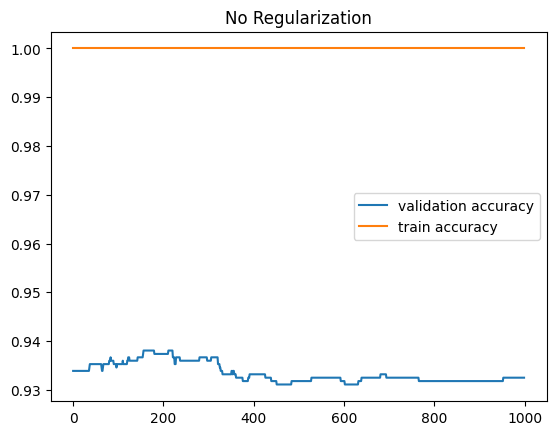

GMC Accuracy: 0.9361111111111111
KNN Accuracy: 0.9222222222222223
Random Forest Accuracy: 0.9


In [82]:
plt.title("No Regularization")
plt.plot(model.val_history, label = "validation accuracy")
plt.plot(model.train_history, label = "train accuracy")
plt.legend()
plt.show()

# import random forest and xgboost for benchmarking
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

# # xgboost
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# xgb_predictions = xgb.predict(X_test)


print("GMC Accuracy:",accuracy_score(gmc_predictions, y_test))
print("KNN Accuracy:",accuracy_score(knn_predictions, y_test))
print("Random Forest Accuracy:", accuracy_score(rf_predictions, y_test))
# print("XGBoost Accuracy:", accuracy_score(xgb_predictions, y_test))


# # confusion matrix
# confusion_matrix(y_test, gmc_predictions)
# confusion_matrix(y_test, knn_predictions)
# confusion_matrix(y_test, xgb_predictions)
# confusion_matrix(y_test, rf_predictions)

In [83]:
model_reg = model3(learning_rate=.2, reg = 0)
model_reg.fit(X_train, y_train, X_val_set= X_train_val, y_val_set= y_train_val)
gmc_predictions_reg = model_reg.predict(X_test)

(0) Val Accuracy: 0.93319.   Train Accuracy: 1.0
(10) Val Accuracy: 0.93598.   Train Accuracy: 1.0
(20) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(30) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(40) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(50) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(60) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(70) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(80) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(90) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(100) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(110) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(120) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(130) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(140) Val Accuracy: 0.93737.   Train Accuracy: 1.0
(150) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(160) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(170) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(180) Val Accuracy: 0.93807.   Train Accuracy: 1.0
(190) Val Accuracy: 0.93807.   Train Accur

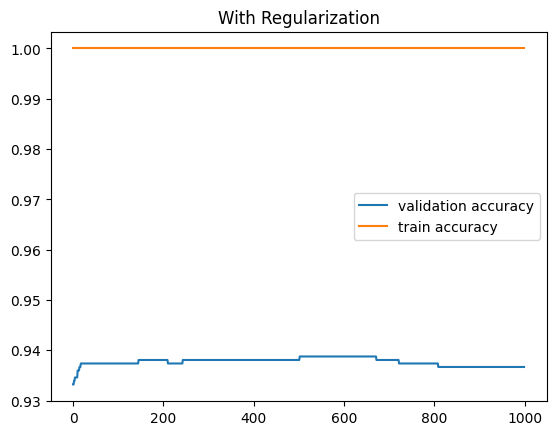

GMC Reg Accuracy: 0.9472222222222222
KNN Accuracy: 0.9222222222222223
Random Forest Accuracy: 0.9


In [84]:
plt.title("With Regularization")
plt.plot(model_reg.val_history, label = "validation accuracy")
plt.plot(model_reg.train_history, label = "train accuracy")
plt.legend()
plt.show()

print("GMC Reg Accuracy:",accuracy_score(gmc_predictions_reg, y_test))
print("KNN Accuracy:",accuracy_score(knn_predictions, y_test))
print("Random Forest Accuracy:", accuracy_score(rf_predictions, y_test))
#print("XGBoost Accuracy:", accuracy_score(xgb_predictions, y_test))

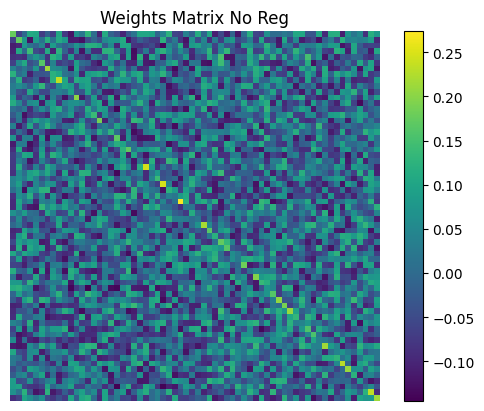

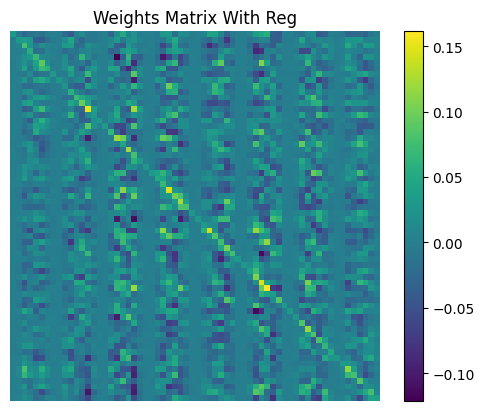

In [85]:
weights = model_reg.weights
reg_weights = model.weights

plt.title("Weights Matrix No Reg")
plt.imshow(weights)
plt.colorbar()
plt.axis('off')
plt.show()

plt.title("Weights Matrix With Reg")
plt.imshow(reg_weights)
plt.colorbar()
plt.axis('off')
plt.show()

Rank of not reg matrix: 60
Rank of reg matrix: 56
Rank of random matrix: 60


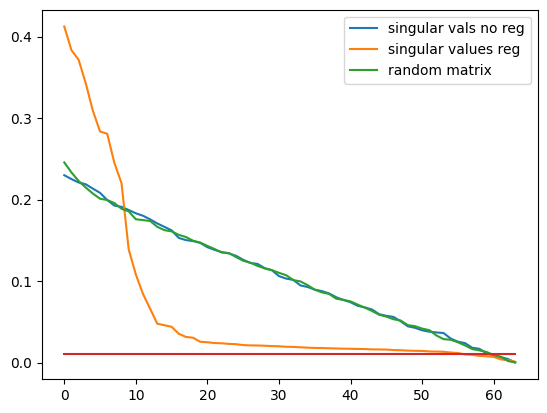

In [86]:
lim = 1e-2
u,s,v  = np.linalg.svd(weights / np.linalg.norm(weights))
rank = np.sum(s > lim)
print("Rank of not reg matrix:", rank)

u_reg,s_reg,v_reg  = np.linalg.svd(reg_weights/ np.linalg.norm(reg_weights))
rank_reg = np.sum(s_reg > lim)
print("Rank of reg matrix:", rank_reg)

rand_mat = np.random.random((64,64))*2 - 1
rand_mat = rand_mat / np.linalg.norm(rand_mat)
u_rand, s_rand, v_rand = np.linalg.svd(rand_mat)
rank_rand = np.sum(s_rand > lim)
print("Rank of random matrix:", rank_rand)



plt.plot(s, label = "singular vals no reg")
plt.plot(s_reg, label='singular values reg')
plt.plot(s_rand, label = "random matrix")
plt.plot(np.ones(64)*lim)
plt.legend()
plt.show()

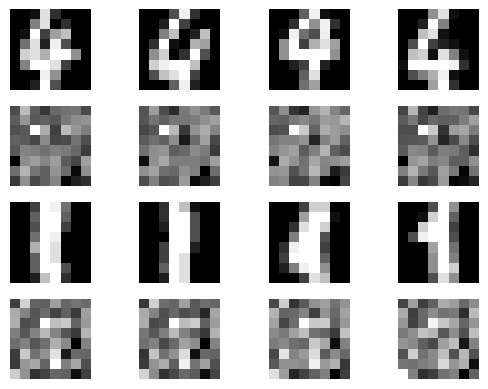

In [78]:
# show an image of the train data
target = [4,1]
count = 4
reg = False

plt.figure()
for i,t in enumerate(target):
    index = 0
    success = 0
    while success < count:

        
        if y_train[index] == t:
            plt.subplot(2*len(target),count,2*i*count+success+1)
            plt.imshow(X_train[index].reshape(8,8), cmap='gray')
            plt.axis('off')
            plt.subplot(2*len(target),count,2*i*count+count+success+1)
            if reg == True:
                weights = model_reg.weights
            else:
                weights = model.weights
            plt.imshow((weights @ X_train[index]).reshape(8,8), cmap='gray')
            plt.axis('off')
            success += 1
        index += 1
        
plt.show()

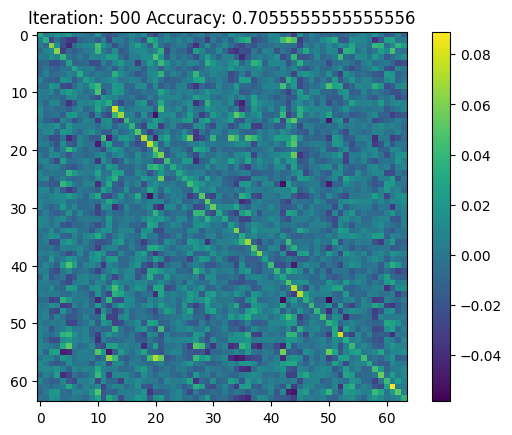

In [79]:
iter = 500

model_copy = model.copy()
model_copy.weights = model_copy.weights_history[iter]
y_preds = model_copy.predict(X_test)
accuracy = accuracy_score(y_preds, y_test)


plt.title(f"Iteration: {iter} Accuracy: {accuracy}")
plt.imshow(model_copy.weights)
plt.colorbar()
plt.show()

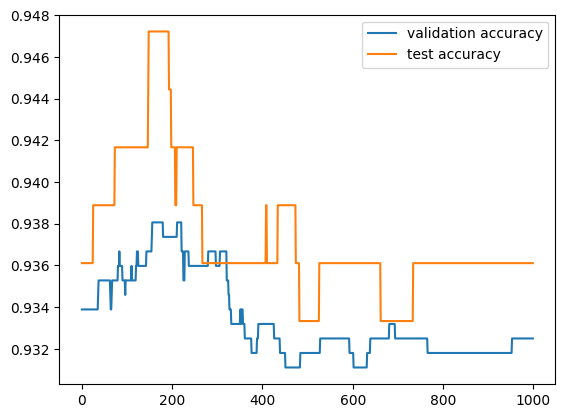

In [87]:
model_temp = model.copy()
test_score =[]
for i in range(len(model.weights_history)):
    model_temp.weights = model.weights_history[i]
    predictions = model_temp.predict(X_test)
    test_score.append(accuracy_score(predictions, y_test))


plt.plot(model.val_history, label = "validation accuracy")
plt.plot(test_score, label = "test accuracy")
plt.legend()
plt.show()